In [1]:
from binance.client import Client
import os
import json
from binance import ThreadedWebsocketManager
import numpy as np
import pandas as pd
from talib.abstract import MACD

In [2]:
with open('../config/key.json') as j:
    keys = json.load(j)


In [3]:
client = Client(keys['api_key'], keys['api_secret'])
dict_data = {'error':False}
bsm = ThreadedWebsocketManager()

In [19]:
starttime = '1 day ago UTC'
interval = '1m'
bars = client.get_historical_klines(data["symbol"], interval, starttime)
for line in bars:
    del line[5:]
# bars = [ del line[5:] for line in bars]
# print(bars)

In [10]:
bsm.stop()
# bsm.stop_socket()
# bsm.stop_client()

In [4]:
def calculate_signal(df):
    """
    1440 is number of data
    778 is 54 percent of 1440 
    """
    # EMA 12 
    ShortEMA =  df.close.ewm(span=12, adjust=False).mean()
    # EMA 26 
    LongEMA = df.close.ewm(span=26, adjust=False).mean()
    # MACD Line
    MACD =  ShortEMA - LongEMA
    # signal Line
    signal = MACD.ewm(span=9, adjust=False).mean()
    return MACD,signal

In [4]:
plot_macd = []
plot_signal = []

In [5]:
def buyORsell(macd_var,signal_var):
#     buy
    # print(f"macd:{MACD.iloc[-1::].values[0]}, signal:{signal.iloc[-1::].values[0]}")
    plot_macd.append(macd_var[-1])
    plot_signal.append(signal_var[-1])
    if macd_var[-1]>signal_var[-1]:
        # print('buy percent:',(signal.iloc[-1::].values[0]-MACD.iloc[-1::].values[0])/MACD.iloc[-1::].values[0])
        # if (signal.iloc[-1::].values[0]-MACD.iloc[-1::].values[0])/MACD.iloc[-1::].values[0] > 0.2:
        return 0 #False
#     sell
    elif macd_var[-1]<signal_var[-1]:
        # print('sell percent:',(MACD.iloc[-1::].values[0]-signal.iloc[-1::].values[0])/signal.iloc[-1::].values[0])
        # if (MACD.iloc[-1::].values[0]-signal.iloc[-1::].values[0])/signal.iloc[-1::].values[0] > 0.2:
        return 1 #True

    return 3

In [6]:
data = {
    "price_buy":[],
    "price_sell":[],
    "p_open":0,
    "status":True,
    "sell":0,
    "sw":False,
    "first":True,
    "symbol":"ETHBUSD",
    "starttime": "30 day ago UTC",
    "interval":"1m"
}

print('init get data')
bars = client.get_historical_klines(data["symbol"], data["interval"], data["starttime"])
bars = [line[4] for line in bars]
df = pd.DataFrame(bars, columns=['close'])
print('finish get data')
plot_macd = []
plot_signal = []

def btc_trade_history(msg):
    global data,bsm,df

    if data['status'] != True:
        bsm.stop()
        
    if msg['e'] != 'error':
#         calculate
        if data['first']:
            data['first'] = False
            data['p_open'] = msg['k']['o']
            print('p_open:',data['p_open'])
        else:
            if float(msg['k']['o']) != float(data['p_open']):
                # state change 
                print('state change:',data['p_open'])
                df = df.iloc[1: , :]
                df2 = pd.DataFrame([msg['k']["o"]],columns=['close'])
                df = pd.concat([df, df2], ignore_index = True, axis = 0)
                
        if float(msg['k']['o']) != float(data['p_open']) or data['first']:
            # calculate signal and MACD
            macd, signal,_ = MACD(df['close'])
            sORb = buyORsell(macd, signal)

            # sell
            if data['sw']:
                # check price sell>buy
                if sORb:
                    if float(msg['k']['o']) > float(data["price_buy"][-1]):
                        # order_sell = client.order_market_sell(symbol=data['symbol'],quantity=round(float(sell_price),4))
                        # print('order_sell:',order_sell)
                        data["price_sell"].append(msg['k']['o'])
                        # save price sell
                        data['price'] = msg['k']['o']
                        print('sell:',data['price'])
                        # change status sw to False
                        data['sw'] = False
            # buy
            else:
                if not sORb:
                    # order_buy = client.order_market_buy(symbol=data['symbol'],quantity=buy_coin)
                    data["price_buy"].append(msg['k']['o'])
                    print('buy:',msg['k']['o'])
                    # data["price"] = float(msg['k']['c'])
                    data['sw'] = True
                    
            # change value
            data['p_open'] = msg['k']['o']
            print('changed:',data['p_open'])
                    
        dict_data['error'] = False
    else:
        dict_data['error'] = True

init get data
finish get data


In [7]:
bsm.start()
print('starting ...... ')
# bsm.start_symbol_ticker_socket(callback=btc_trade_history, symbol=data["symbol"])
bsm.start_kline_futures_socket(callback=btc_trade_history, symbol=data["symbol"],interval="1m")
# bsm.start_kline_socket(callback= btc_trade_history,symbol=data["symbol"])

starting ...... 


'ethbusd_perpetual@continuousKline_1m'

p_open: 1677.33
state change: 1677.33
buy: 1677.54
changed: 1677.54
state change: 1677.54
changed: 1675.75
state change: 1675.75
changed: 1677.45
state change: 1677.45
changed: 1676.11
state change: 1676.11
changed: 1676.25
state change: 1676.25
changed: 1675.92
state change: 1675.92
changed: 1674.50
state change: 1674.50
changed: 1675.38
state change: 1675.38
changed: 1674.00
state change: 1674.00
changed: 1671.98
state change: 1671.98
changed: 1670.30
state change: 1670.30
changed: 1669.50
state change: 1669.50
changed: 1671.09
state change: 1671.09
changed: 1669.30
state change: 1669.30
changed: 1671.01
state change: 1671.01
changed: 1671.90
state change: 1671.90
changed: 1669.93
state change: 1669.93
changed: 1672.00
state change: 1672.00
changed: 1671.64
state change: 1671.64
changed: 1669.47
state change: 1669.47
changed: 1670.55
state change: 1670.55
changed: 1670.49
state change: 1670.49
changed: 1669.75
state change: 1669.75
changed: 1668.13
state change: 1668.13
changed: 1665

In [122]:
data['p_open']

'1186.09'

In [133]:
data["price_buy"]

['1139.79',
 '1190.73',
 '1193.13',
 '1192.22',
 '1196.19',
 '1194.70',
 '1200.49',
 '1205.74']

In [134]:
data["price_buy"]

['1139.79',
 '1190.73',
 '1193.13',
 '1192.22',
 '1196.19',
 '1194.70',
 '1200.49',
 '1205.74']

In [135]:
data["price_sell"]

['1174.34', '1193.40', '1198.54', '1194.34', '1210.45', '1196.61', '1202.02']

In [116]:
plot_macd

[-0.03686651504881411,
 -0.01440245491994574,
 -0.03014255077459893,
 0.0910883433652998,
 0.05261011691231943,
 0.05058176152147098,
 0.29969821514373507,
 0.6103199584074446,
 1.0094644016091934,
 1.0394554679169232,
 1.1093407139655937,
 1.0860389470351492,
 1.1846368339470246,
 1.1550524224510355,
 1.1035540667496662,
 1.1527384995565626,
 1.3424671748373385,
 1.8491495594610114,
 2.3072152504400947,
 3.040261415732175,
 3.7689983097275217,
 4.870555724570295,
 5.620658477229654,
 5.847540594245174,
 6.161279682000895,
 6.95271310195767,
 7.536625746060963,
 8.102863564135532,
 8.474897597508743,
 8.991278705165769,
 9.038913148997608,
 8.880690412410104,
 8.551818577050653,
 8.132083451603194,
 7.932324211419655,
 7.634366696045845,
 7.175917170370667,
 6.797976178227827,
 6.583145188050594,
 6.475421247734403,
 6.214322191957081,
 5.834437493647556,
 5.376186661711017,
 5.045235877012146,
 4.646283143962819,
 4.298314100759171,
 4.026961555790422,
 3.6871045868745114,
 3.46497044

In [117]:
plot_signal

[0.0626222424609389,
 0.04721730298476198,
 0.031745332232889806,
 0.04361393445937181,
 0.045413170949961335,
 0.046446889064263266,
 0.09709715428015764,
 0.19974171510561503,
 0.36168625240633073,
 0.4972400955084492,
 0.6196602191998781,
 0.7129359647669324,
 0.8072761386029509,
 0.8768313953725678,
 0.9221759296479876,
 0.9682884436297026,
 1.0431241898712298,
 1.2043292637891863,
 1.424906461119368,
 1.7479774520419296,
 2.152181623579048,
 2.6958564437772976,
 3.280816850467769,
 3.7941615992232505,
 4.26758521577878,
 4.804610793014558,
 5.35101378362384,
 5.901383739726179,
 6.416086511282693,
 6.931124950059308,
 7.352682589846968,
 7.658284154359595,
 7.836991038897807,
 7.896009521438884,
 7.903272459435039,
 7.8494913067572005,
 7.7147764794798945,
 7.5314164192294815,
 7.341762172993704,
 7.168493987941844,
 6.977659628744892,
 6.749015201725425,
 6.474449493722544,
 6.188606770380464,
 5.880142045096935,
 5.563776456229383,
 5.256413476141591,
 4.942551698288176,
 4.6470

state change: 1191.30
changed: 1192.70


In [17]:
import matplotlib.pyplot as plt

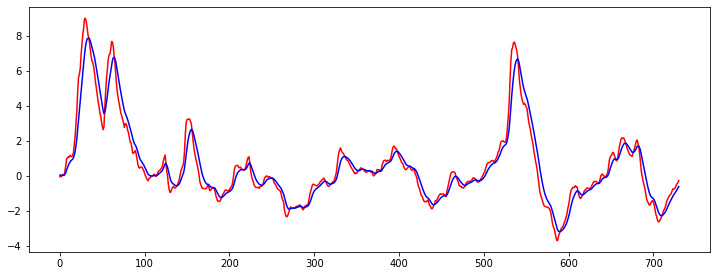

In [128]:
plt.figure(figsize=(12.2, 4.5))
plt.plot(plot_macd, color= 'red')
plt.plot(plot_signal, color= 'blue')
# plt.xticks(rotation=45)
# plt.legend(loc='upper left')
plt.show()

In [8]:
bsm.stop()

In [55]:
# test round 2

In [148]:
bars = client.get_historical_klines(data["symbol"], data["interval"], data["starttime"])
for line in bars:
    del line[5:]
df = pd.DataFrame(bars, columns=['date', 'open', 'high', 'low', 'close'])
# symbol_df, buy_sell_list = macd_trade_logic(df)
# buy_or_sell(symbol_df, buy_sell_list)

Text(0, 0.5, 'Price THB(฿)')

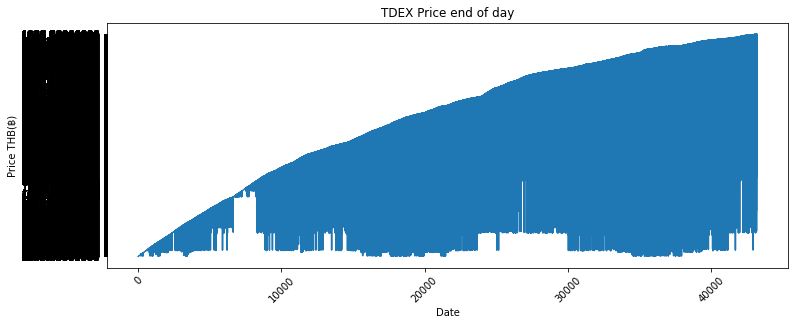

In [149]:
plt.figure(figsize=(12.2, 4.5))
plt.plot(df['close'], label='Close')
plt.xticks(rotation=45)
plt.title('TDEX Price end of day')
plt.xlabel('Date')
plt.ylabel('Price THB(฿)')

In [22]:
# คำนวณ EMA 12 
ShortEMA =  df.close.ewm(span=12, adjust=False).mean()
# คำนวณ EMA 26 
LongEMA = df.close.ewm(span=26, adjust=False).mean()
# คำนวณ MACD Line
MACD =  ShortEMA - LongEMA
# # คำนวณ MACD Line
signal = MACD.ewm(span=9, adjust=False).mean()

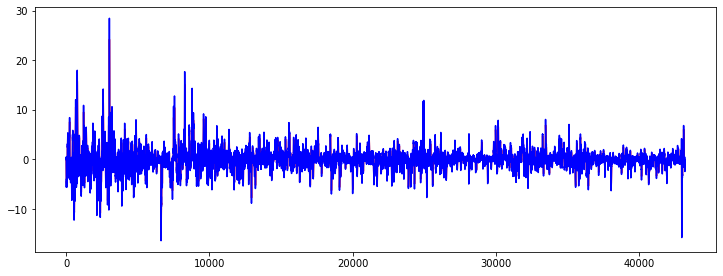

In [151]:
plt.figure(figsize=(12.2, 4.5))
plt.plot(df.index, signal, label='TDEX MACD', color= 'red')
plt.plot(df.index, MACD, label='Signal Line', color= 'blue')
# plt.xticks(rotation=45)
# plt.legend(loc='upper left')
plt.show()

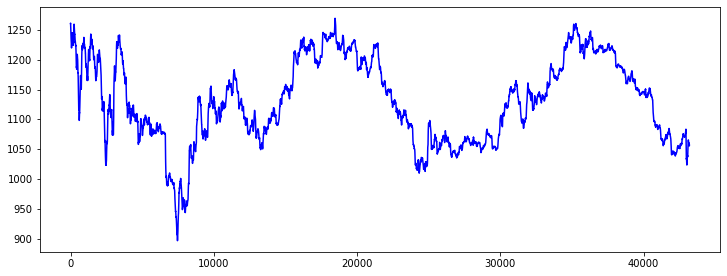

In [152]:
plt.figure(figsize=(12.2, 4.5))
# plt.plot(df.index, LongEMA, label='TDEX MACD', color= 'red')
plt.plot(df.index, LongEMA, label='Signal Line', color= 'blue')
# plt.xticks(rotation=45)
# plt.legend(loc='upper left')
plt.show()

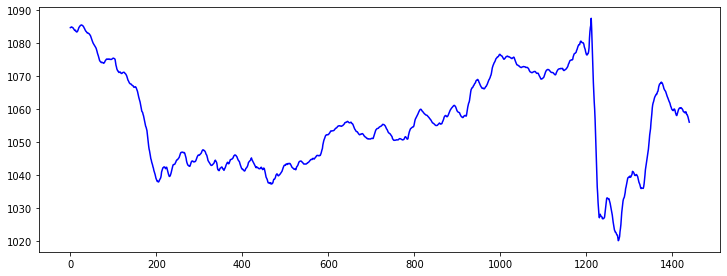

In [144]:
plt.figure(figsize=(12.2, 4.5))
# plt.plot(df.index, LongEMA, label='TDEX MACD', color= 'red')
plt.plot(df.index, ShortEMA, label='Signal Line', color= 'blue')
# plt.xticks(rotation=45)
# plt.legend(loc='upper left')
plt.show()

In [87]:
df['MACD'] = MACD
df['Signal line'] = signal

In [89]:
a = buy_sell(signal)

In [91]:
df['Buy_Signal_Price'] = a[0]
df['Sell_Signal_Price'] = a[1]

In [104]:
df.to_excel('test.xlsx')

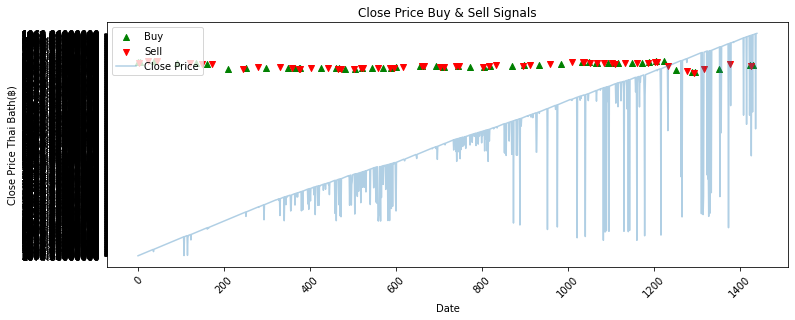

In [92]:
plt.figure(figsize=(12.2, 4.5))
plt.scatter(df.index, df['Buy_Signal_Price'], color='green', label='Buy', marker='^', alpha=1)
plt.scatter(df.index, df['Sell_Signal_Price'], color='red', label='Sell', marker='v', alpha=1)
plt.plot(df['close'], label='Close Price', alpha = 0.35)
plt.title('Close Price Buy & Sell Signals')
plt.xticks(rotation = 45)
plt.xlabel('Date')
plt.ylabel('Close Price Thai Bath(฿)')
plt.legend(loc = 'upper left')
plt.show()

In [215]:
MACD.iloc[-1::].values[0]

0.3911886820130803

In [212]:
MACD.iloc[-1::]

43200    0.391189
Name: close, dtype: float64

In [217]:
signal.iloc[-1::].values[0]

-0.6449855288451596

In [221]:
MACD,signal = calculate_signal(df)

In [7]:
data = {
    "price_buy":[],
    "price_sell":[],
    "status":True,
    "sell":0,
    "sw":False,
    "first":True,
    "symbol":"ETHBUSD",
    "starttime": "1 day ago UTC",
    "interval":"1m",
}

In [11]:
data = {
    "price_buy":[],
    "price_sell":[],
    "status":True,
    "sell":0,
    "sw":False,
    "first":True,
    "symbol":"ETHBUSD",
    "starttime": "1 day ago UTC",
    "interval":"1m",
}
bars = client.get_historical_klines(data["symbol"], data["interval"], data["starttime"])
bars = [line[4] for line in bars]
len(bars)

1440

In [ ]:
def btc_trade_history(msg):
    global df
    if msg['e'] != 'error':
#       get history price
        print('first:',data['first'])
        if data['first']:
            bars = client.get_historical_klines(data["symbol"], data["interval"], data["starttime"])
            bars = [line[4] for line in bars]
            data['first'] = False
            df = pd.DataFrame(bars, columns=['close'])
        else:
            df = df.iloc[1: , :]
            df = df.append({"close":msg['k']["c"]}, ignore_index = True)
        
        macd,signal = calculate_signal(df)
        buy_sell()
        dict_data['error'] = False
    else:
        dict_data['error'] = True

In [8]:
bars = client.get_historical_klines(data["symbol"], data["interval"], data["starttime"])
bars = [line[4] for line in bars]
df = pd.DataFrame(bars, columns=['close'])

In [9]:
df.head()

,close
0,1076.16000000
1,1076.21000000
2,1075.78000000
3,1076.24000000
4,1076.10000000


In [10]:
df = df.iloc[1: , :]
df

,close
1,1076.21000000
2,1075.78000000
3,1076.24000000
4,1076.10000000
5,1075.09000000
...,...
1435,1086.27000000
1436,1085.91000000
1437,1086.77000000
1438,1086.26000000


In [11]:
df.tail()

,close
1435,1086.27000000
1436,1085.91000000
1437,1086.77000000
1438,1086.26000000
1439,1086.74000000


In [184]:
dict_add = {"close":1}
df = df.append(dict_add, ignore_index = True)

/var/folders/xw/bkhsfhfx7d3br4jrf0tq3w4w0000gn/T/ipykernel_4963/2710902026.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dict_add, ignore_index = True)


In [16]:
# df2 = {"close":1}
df2 = pd.DataFrame([1],columns=['close'])
df = pd.concat([df, df2], ignore_index = True, axis = 0)

In [17]:
df.tail()

,close
1436,1086.77000000
1437,1086.26000000
1438,1086.74000000
1439,1
1440,1


In [ ]:
ถ้า long มากกว่า short ขาย
ถ้า short มากกว่า long ซื้อ

In [1]:
import re

In [10]:
r = re.findall(r'\d','098 889 5624')
r = [int(i) for i in r]
r

[0, 9, 8, 8, 8, 9, 5, 6, 2, 4]

In [11]:
sum(r)

59